In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import skorch

In [2]:
from functools import partial

In [3]:
import numpy as np

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [5]:
from deepspeech.model import DeepSpeech
from deepspeech.model import SequenceWise
from deepspeech.data.data_loader import SpectrogramParser
from deepspeech.data.data_loader import BucketingSampler

In [8]:
from data import dataset
from utils import RNNValueExtractor
from utils import Identity
from utils import bucketing_dataloader
from layers import ResidualRNN

In [9]:
base_model = DeepSpeech.load_model(
    'models/librispeech_pretrained.pth'
)
audio_conf = DeepSpeech.get_audio_conf(base_model)
parser = SpectrogramParser(audio_conf)

In [100]:
ds_swear = dataset.SwearDataset(dataset.DEFAULT_PROVIDERS)

In [101]:
X_swear, y_swear = ds_swear.load()

In [80]:
ds = dataset.SwearBinaryAudioDataset(X_swear, y_swear, parser)

In [81]:
X, y = ds.load()

(7, 11)

General swear / noswear class balance

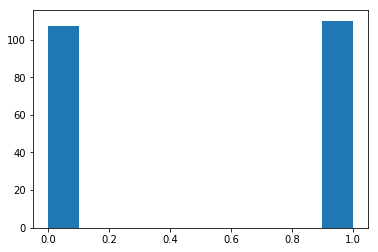

In [17]:
plt.hist(y);

In [18]:
seq_lens = np.array([x.shape[1] for x in X])
max_seq_len = max(seq_lens)
max_seq_len, np.mean(seq_lens), np.median(seq_lens)

(663, 233.85714285714286, 173.0)

In [19]:
X_pad = np.zeros(
    (len(X), X[0].shape[0], max_seq_len), 
    dtype='float32'
)
for i, _ in enumerate(X):
    X_pad[i, :, :seq_lens[i]] = X[i]

In [20]:
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [21]:
train_idcs, test_idcs = next(split.split(y, y=y))

In [22]:
X_train = {'lens': seq_lens[train_idcs], 'X': X_pad[train_idcs]}
y_train = np.array(y)[train_idcs]

X_test = {'lens': seq_lens[test_idcs], 'X': X_pad[test_idcs]}
y_test = np.array(y)[test_idcs]

In [23]:
len(X_train['X']), len(X_test['X'])

(173, 44)

In [43]:
class NoSwearModel(torch.nn.Module):
    def __init__(
        self, 
        base_model, 
        residual=False, 
        n_hidden=10, 
        n_layer=1,
        p_dropout=0.2
    ):
        super().__init__()
        self.base_model = base_model
        self.base_model.rnns = Identity()
        self.base_model.lookahead = Identity()
        self.base_model.fc = Identity()
        self.base_model.inference_softmax = Identity()
        
        if residual:
            self.rnn = torch.nn.Sequential(
                torch.nn.GRU(     672, n_hidden, bias=False, batch_first=True),
                RNNValueExtractor(),
                ResidualRNN(torch.nn.GRU(n_hidden, n_hidden, bias=False, batch_first=True)),
            )
        else:
            self.rnn = torch.nn.Sequential(
                torch.nn.GRU(672, n_hidden, num_layers=n_layer, bias=False, batch_first=True),
                RNNValueExtractor(),
            )
            
        self.clf = torch.nn.Linear(n_hidden, 2)
        self.dropout = torch.nn.Dropout(p=p_dropout)
        
    def forward(self, X, lens):
        # run base model, output is NxTxH with
        # T=Time, N=samples, H=hidden.
        y_pre = self.base_model(X)
        y_pre = self.dropout(y_pre)
        
        # run RNN over sequence and extract last item
        y = self.rnn(y_pre)
        # presumably we cannot use lens since cnns reduce that too
        #y = y[:, lens - 1]
        #y = y[:, -1]
        i = y.mean(-1).argmax(1)
        y = y[torch.arange(len(y)), i]
        
        y = self.dropout(y)
        
        # run classifier
        y = self.clf(y)
        y = torch.softmax(y, dim=-1)
        return y

In [44]:
def bucket(Xi, yi):
    Xi['X'] = Xi['X'][:, :, :max(Xi['lens'])]
    return Xi, yi

In [59]:
torch.manual_seed(42)

net = skorch.NeuralNetClassifier(
    partial(NoSwearModel, base_model), 
    
    iterator_train=bucketing_dataloader,
    iterator_train__bucket_fn=bucket,
    iterator_valid=bucketing_dataloader,
    iterator_valid__bucket_fn=bucket,
    
    batch_size=64,
    max_epochs=40,
    device='cuda',
    
    module__p_dropout=0.5,
    module__n_hidden=20,
    module__residual=True,
        
    optimizer=torch.optim.RMSprop,
    optimizer__lr=0.0001,
    #optimizer__weight_decay=1e-4,
    
    callbacks=[
        skorch.callbacks.Freezer('base_model.*'),
        skorch.callbacks.Checkpoint(monitor='valid_acc_best'),
    ]
)

In [60]:
%pdb on
net.fit(X_train, y_train)

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.8685       0.5714        0.7163     +  0.2748
      2        0.8422       0.5429        0.7086        0.2886
      3        0.7534       0.5429        0.7099        0.3027
      4        0.8138       0.4857        0.7204        0.3028
      5        0.8156       0.4857        0.7214        0.3006
      6        0.7884       0.4571        0.7316        0.3025
      7        0.7780       0.4571        0.7356        0.3012
      8        0.7701       0.5143        0.7340        0.3030
      9        0.7326       0.5429        0.7381        0.3077
     10        0.7428       0.5429        0.7288        0.3049
     11        0.8088       0.5143        0.7288        0.2964
     12        0.7776       0.4857        0.7424        0.3066
     13        0.7671       0.5429        0.7261        0.3046
     14       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=NoSwearModel(
    (base_model): DeepSpeech(
      (conv): Sequential(
        (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(0, 10))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0, max_val=20, inplace)
        (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Hardtanh(min_val=0, max_val=20, inplace)
      )
      (rnns): Identity()
      (fc): Identity()
      (inference_softmax): Identity()
      (lookahead): Identity()
    )
    (rnn): Sequential(
      (0): GRU(672, 20, bias=False, batch_first=True)
      (1): RNNValueExtractor()
      (2): ResidualRNN(
        (rnn): GRU(20, 20, bias=False, batch_first=True)
      )
    )
    (clf): Linear(in_features=20, out_features=2, bias=True)
    (dropout): Dropout(p

In [61]:
accuracy_score(y_test, net.predict(X_test))

0.5454545454545454

In [62]:
from sklearn.model_selection import GridSearchCV
from skorch.helper import SliceDict

In [63]:
net.initialize();
net.set_params(verbose=False);

Re-initializing module because the following parameters were re-set: n_hidden, p_dropout, residual.
Re-initializing optimizer because the following parameters were re-set: lr.


In [64]:
params = {
    'optimizer__lr': [0.02, 0.002, 0.0002],
    'optimizer__weight_decay': [0, 1e-4],
    'optimizer': [torch.optim.RMSprop, torch.optim.Adam],
    'module__p_dropout': [0, 0.5],
    'module__n_hidden': [5, 10, 20, 40],
    'module__n_layer': [1, 2],
    'module__residual': [True, False],
}

In [65]:
gs = GridSearchCV(net, params, scoring='accuracy')

In [66]:
%%time
gs.fit(SliceDict(**X_train), y_train);

/data/tietz/envs/noswear/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/data/tietz/envs/noswear/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 4h 10min 33s, sys: 1h 23min 16s, total: 5h 33min 49s
Wall time: 5h 33min 44s


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=NoSwearModel(
    (base_model): DeepSpeech(
      (conv): Sequential(
        (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(0, 10))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, ... )
    (clf): Linear(in_features=20, out_features=2, bias=True)
    (dropout): Dropout(p=0.5)
  ),
),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'optimizer': [<class 'torch.optim.rmsprop.RMSprop'>, <class 'torch.optim.adam.Adam'>], 'module__residual': [True, False], 'module__p_dropout': [0, 0.5], 'module__n_layer': [1, 2], 'optimizer__weight_decay': [0, 0.0001], 'optimizer__lr': [0.02, 0.002, 0.0002], 'module__n_hidden': [5, 10, 20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [74]:
import pandas as pd
results = pd.DataFrame(gs.cv_results_)

In [77]:
results.sort_values(by='mean_test_score').head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_module__n_hidden,param_module__n_layer,param_module__p_dropout,param_module__residual,param_optimizer,param_optimizer__lr,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
155,17.536851,0.182521,0.138728,0.673163,10,2,0,True,<class 'torch.optim.adam.Adam'>,0.0002,...,0.0,0.73913,0.413793,0.521739,0.000000,0.758621,0.122688,0.009504,0.195344,0.107368
41,16.155941,0.184054,0.144509,0.678961,5,1,0.5,False,<class 'torch.optim.rmsprop.RMSprop'>,0.0002,...,0.0,0.73913,0.431034,0.539130,0.000000,0.758621,0.104287,0.016025,0.203483,0.099194
92,17.130797,0.180400,0.144509,0.664493,5,2,0.5,False,<class 'torch.optim.adam.Adam'>,0.002,...,0.0,0.73913,0.431034,0.504348,0.000000,0.750000,0.273316,0.006085,0.203483,0.113326
232,16.109684,0.184262,0.156069,0.670315,20,1,0.5,False,<class 'torch.optim.rmsprop.RMSprop'>,0.0002,...,0.0,0.73913,0.448276,0.530435,0.017544,0.741379,0.183906,0.011124,0.207641,0.098914
58,17.600718,0.193797,0.156069,0.676037,5,2,0,True,<class 'torch.optim.adam.Adam'>,0.0002,...,0.0,0.73913,0.448276,0.521739,0.017544,0.767241,0.216381,0.021920,0.207641,0.109707
37,16.238465,0.178773,0.161850,0.664468,5,1,0.5,False,<class 'torch.optim.rmsprop.RMSprop'>,0.02,...,0.0,0.73913,0.482759,0.495652,0.000000,0.758621,0.149178,0.005524,0.227901,0.119636
169,18.049926,0.194965,0.161850,0.664468,10,2,0.5,True,<class 'torch.optim.rmsprop.RMSprop'>,0.02,...,0.0,0.73913,0.482759,0.495652,0.000000,0.758621,0.333862,0.013752,0.227901,0.119636
45,16.319578,0.183361,0.161850,0.664468,5,1,0.5,False,<class 'torch.optim.adam.Adam'>,0.002,...,0.0,0.73913,0.482759,0.495652,0.000000,0.758621,0.103392,0.009492,0.227901,0.119636
280,16.964788,0.196066,0.161850,0.661594,20,2,0.5,False,<class 'torch.optim.rmsprop.RMSprop'>,0.0002,...,0.0,0.73913,0.482759,0.495652,0.000000,0.750000,0.241696,0.018208,0.227901,0.117423
281,17.147984,0.186713,0.161850,0.664468,20,2,0.5,False,<class 'torch.optim.rmsprop.RMSprop'>,0.0002,...,0.0,0.73913,0.482759,0.495652,0.000000,0.758621,0.129971,0.017353,0.227901,0.119636


In [67]:
net.set_params(verbose=True, **gs.best_params_);

Re-initializing module because the following parameters were re-set: n_hidden, n_layer, p_dropout, residual.
Re-initializing optimizer because the following parameters were re-set: lr.


In [68]:
net.fit(X_train, y_train);

Re-initializing module because the following parameters were re-set: n_hidden, n_layer, p_dropout, residual.
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.9350       0.5143        0.7613     +  0.5739
      2        0.7826       0.5143        0.7609        0.5689
      3        0.7887       0.5143        0.7599        0.5877
      4        0.8040       0.5143        0.7494        0.6058
      5        0.8975       0.5143        0.7483        0.5984
      6        0.8115       0.5143        0.7380        0.5842
      7        0.8591       0.5143        0.7448        0.6227
      8        0.8148       0.5143        0.7434        0.6281
      9        0.9639       0.5143        0.7423        0.5985
     10        0.7615       0.5143        0.7411        0.6302
     11        0.8135       0.5143        0.7

In [69]:
accuracy_score(y_test, net.predict(X_test))

0.5227272727272727